<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B05%5D%20-%20Arboles%20de%20decision/Evaluacion_y_Optimizacion_Largo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluacion y Optimizaci√≥n de Modelos - Ejercicio 8: Evaluacion_y_Optimizacion_Largo.ipynb

Este notebook es **We do**: lo hacemos juntos. Algunas celdas est√°n resueltas para guiarte en las partes complejas, pero encontrar√°s comentarios `# TODO` dentro del c√≥digo que debes completar durante la sesi√≥n. Ejecuta las celdas en orden, experimenta con los par√°metros y anota tus decisiones.

## Objetivos

- Dataset Titanic de OpenML
- Limpieza y preparaci√≥n de datos
- B√∫squeda de hiperpar√°metros
- Regularizaci√≥n y Early Stopping
- Validaci√≥n y detecci√≥n de overfitting
- M√©tricas de evaluaci√≥n

In [ ]:
!pip install scikit-optimize lightgbm

In [ ]:
# Librer√≠as y configuraci√≥n (resuelto)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve, learning_curve
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gr√°ficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Intentar importar librer√≠as opcionales
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    print("XGBoost no disponible. Instala con: pip install xgboost")
    xgboost_available = False

try:
    import lightgbm as lgb
    lightgbm_available = True
except ImportError:
    print("LightGBM no disponible. Instala con: pip install lightgbm")
    lightgbm_available = False

try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    bayesian_available = True
except ImportError:
    print("Para optimizaci√≥n bayesiana, instala: pip install scikit-optimize")
    bayesian_available = False

### Carga de datos y preparaci√≥n

Cargar dataset Titanic (dataset est√°ndar y reproducible)

In [ ]:
print("Cargando dataset Titanic desde OpenML...")

# Cargar dataset Titanic (dataset est√°ndar y reproducible)
titanic = fetch_openml('titanic', version=1, as_frame=True)
df = titanic.frame

print(f"Dataset cargado. Shape: {df.shape}")
print(f"Columnas disponibles: {list(df.columns)}")
print(f"\nPrimeras 5 filas:")
print(df.head())

Cargando dataset Titanic desde OpenML...
Dataset cargado. Shape: (1309, 14)
Columnas disponibles: ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']

Primeras 5 filas:
   pclass survived                                             name     sex  \
0       1        1                    Allen, Miss. Elisabeth Walton  female   
1       1        1                   Allison, Master. Hudson Trevor    male   
2       1        0                     Allison, Miss. Helen Loraine  female   
3       1        0             Allison, Mr. Hudson Joshua Creighton    male   
4       1        0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C

In [ ]:
# Preparaci√≥n de datos
print("\nPreparando datos...")
features_to_use = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
df_clean = df[features_to_use + ['survived']].copy()

print(f"Valores faltantes por columna:")
print(df_clean.isnull().sum())


Preparando datos...
Valores faltantes por columna:
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
survived      0
dtype: int64



Limpiando datos...
Valores faltantes despu√©s de rellenar:
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64

Convirtiendo variables categ√≥ricas a num√©ricas...
Convirtiendo sex de category a numeric...
Convirtiendo embarked de category a numeric...
Convirtiendo survived de category a numeric...

Tipos de datos finales:
pclass        int64
sex           int64
age         float64
sibsp         int64
parch         int64
fare        float64
embarked      int64
survived      int64
dtype: object

Valores faltantes finales:
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64

Caracter√≠sticas finales: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
Target: survived (tipo: int64)
Distribuci√≥n del target:
survived
0    809
1    500
Name: count, dtype: int64
Proporci√≥n de supervivientes: 0.382


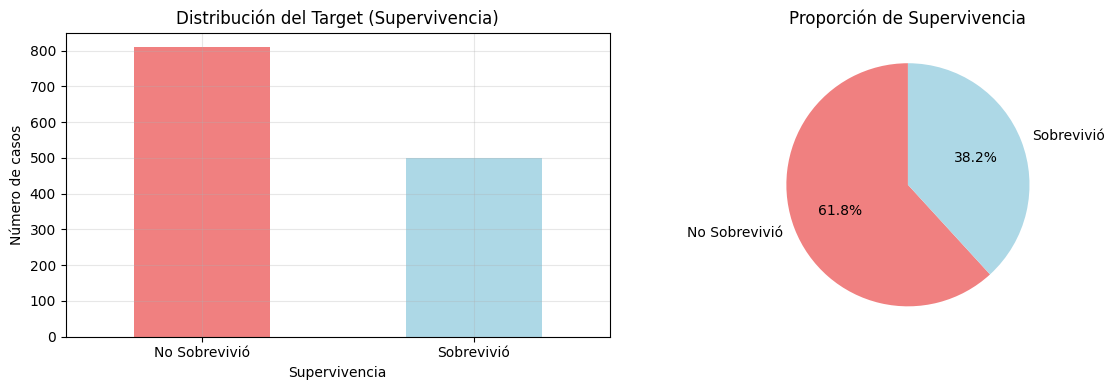

In [ ]:
# Limpiar datos
print("\nLimpiando datos...")

# Rellenar valores faltantes primero
df_clean['age'].fillna(df_clean['age'].median(), inplace=True)
df_clean['embarked'].fillna('S', inplace=True)  # Valor m√°s com√∫n
df_clean['fare'].fillna(df_clean['fare'].median(), inplace=True)

print("Valores faltantes despu√©s de rellenar:")
print(df_clean.isnull().sum())

# Convertir variables categ√≥ricas a num√©ricas
print("\nConvirtiendo variables categ√≥ricas a num√©ricas...")

# Convertir sex
if df_clean['sex'].dtype == 'category' or df_clean['sex'].dtype == 'object':
    df_clean['sex'] = df_clean['sex'].map({'male': 0, 'female': 1})
    if df_clean['sex'].isnull().any():
        # Si hay valores no mapeados, usar c√≥digos categ√≥ricos
        df_clean['sex'] = pd.Categorical(df_clean['sex']).codes

# Convertir embarked
if df_clean['embarked'].dtype == 'category' or df_clean['embarked'].dtype == 'object':
    df_clean['embarked'] = df_clean['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    if df_clean['embarked'].isnull().any():
        # Si hay valores no mapeados, usar c√≥digos categ√≥ricos
        df_clean['embarked'] = pd.Categorical(df_clean['embarked']).codes

# Asegurar que todas las columnas sean num√©ricas
for col in df_clean.columns:
    if df_clean[col].dtype == 'category':
        print(f"Convirtiendo {col} de category a numeric...")
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    elif df_clean[col].dtype == 'object':
        print(f"Convirtiendo {col} de object a numeric...")
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Rellenar cualquier NaN que pueda haber resultado de la conversi√≥n
df_clean.fillna(0, inplace=True)

print("\nTipos de datos finales:")
print(df_clean.dtypes)
print("\nValores faltantes finales:")
print(df_clean.isnull().sum())

# Separar caracter√≠sticas y target
X = df_clean.drop('survived', axis=1)
y = df_clean['survived']

# Convertir y a num√©rico si es categ√≥rico
if y.dtype == 'category' or y.dtype == 'object':
    print("Convirtiendo target categ√≥rico a num√©rico...")
    # Mapear valores categ√≥ricos a num√©ricos
    if y.dtype == 'category':
        y = y.cat.codes
    else:
        # Si es string, mapear manualmente
        y = y.map({'0': 0, '1': 1, 0: 0, 1: 1}).astype(int)

print(f"\nCaracter√≠sticas finales: {list(X.columns)}")
print(f"Target: {y.name} (tipo: {y.dtype})")
print(f"Distribuci√≥n del target:")
print(y.value_counts())
print(f"Proporci√≥n de supervivientes: {y.mean():.3f}")

# Visualizaci√≥n de la distribuci√≥n del target
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
y.value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Distribuci√≥n del Target (Supervivencia)')
plt.xlabel('Supervivencia')
plt.ylabel('N√∫mero de casos')
plt.xticks([0, 1], ['No Sobrevivi√≥', 'Sobrevivi√≥'], rotation=0)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
colors = ['lightcoral', 'lightblue']
plt.pie(y.value_counts(), labels=['No Sobrevivi√≥', 'Sobrevivi√≥'],
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Proporci√≥n de Supervivencia')

plt.tight_layout()
plt.show()

### Preparamos Train y Test

Vemos muestras

In [ ]:
# Dividir datos en train/test
print("\nDividiendo datos en train/test (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} muestras")
print(f"Test set: {X_test.shape[0]} muestras")
print(f"Distribuci√≥n train: {y_train.value_counts().values}")
print(f"Distribuci√≥n test: {y_test.value_counts().values}")


Dividiendo datos en train/test (80/20)...
Training set: 1047 muestras
Test set: 262 muestras
Distribuci√≥n train: [647 400]
Distribuci√≥n test: [162 100]


### Busqueda de Hiperparametros

Tenemos 3 bloques, Grid Search, Random Search y Optimizaci√≥n Bayesiana

In [ ]:
# -----------------------------------------------------------------------------
# 2.1 GRID SEARCH
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("2.1 GRID SEARCH")
print("-"*30)

print("Grid Search realiza una b√∫squeda exhaustiva en todos los par√°metros especificados")

# Random Forest con Grid Search
rf_grid = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

print("Par√°metros a evaluar en Grid Search:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid_rf.values():
    total_combinations *= len(values)
print(f"Total de combinaciones a evaluar: {total_combinations}")

print("\nEjecutando Grid Search...")
grid_search = GridSearchCV(
    rf_grid, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print(f"Mejores par√°metros encontrados: {grid_search.best_params_}")
print(f"Mejor score de validaci√≥n cruzada: {grid_search.best_score_:.4f}")

# Evaluar en test
y_pred_grid = grid_search.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
print(f"Accuracy en conjunto de test: {accuracy_grid:.4f}")

best_rf_grid = grid_search.best_estimator_


------------------------------
2.1 GRID SEARCH
------------------------------
Grid Search realiza una b√∫squeda exhaustiva en todos los par√°metros especificados
Par√°metros a evaluar en Grid Search:
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 10, None]
  min_samples_split: [2, 5, 10]
Total de combinaciones a evaluar: 36

Ejecutando Grid Search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores par√°metros encontrados: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Mejor score de validaci√≥n cruzada: 0.8013
Accuracy en conjunto de test: 0.8092


In [ ]:
# -----------------------------------------------------------------------------
# 2.2 RANDOM SEARCH
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("2.2 RANDOM SEARCH")
print("-"*30)

print("Random Search eval√∫a combinaciones aleatorias de par√°metros")
print("Es m√°s eficiente cuando hay muchos hiperpar√°metros")

if xgboost_available:
    # XGBoost con Random Search
    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

    param_dist_xgb = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    print("Distribuci√≥n de par√°metros para Random Search:")
    for param, values in param_dist_xgb.items():
        print(f"  {param}: {values}")

    n_iter = 20
    print(f"N√∫mero de iteraciones aleatorias: {n_iter}")

    print("Ejecutando Random Search...")
    random_search = RandomizedSearchCV(
        xgb_model, param_dist_xgb, n_iter=n_iter, cv=5,
        scoring='accuracy', random_state=42, n_jobs=-1, verbose=1
    )
    random_search.fit(X_train, y_train)

    print(f"Mejores par√°metros: {random_search.best_params_}")
    print(f"Mejor score CV: {random_search.best_score_:.4f}")

    # Evaluar en test
    y_pred_random = random_search.predict(X_test)
    accuracy_random = accuracy_score(y_test, y_pred_random)
    print(f"Accuracy en test: {accuracy_random:.4f}")

    best_xgb_random = random_search.best_estimator_
else:
    print("XGBoost no disponible, usando Random Forest para Random Search")
    # Usar Random Forest con m√°s par√°metros
    rf_random = RandomForestClassifier(random_state=42)

    param_dist_rf = {
        'n_estimators': [50, 100, 150, 200, 300],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None]
    }

    random_search = RandomizedSearchCV(
        rf_random, param_dist_rf, n_iter=20, cv=5,
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)

    print(f"Mejores par√°metros: {random_search.best_params_}")
    print(f"Mejor score CV: {random_search.best_score_:.4f}")

    y_pred_random = random_search.predict(X_test)
    accuracy_random = accuracy_score(y_test, y_pred_random)
    print(f"Accuracy en test: {accuracy_random:.4f}")



------------------------------
2.2 RANDOM SEARCH
------------------------------
Random Search eval√∫a combinaciones aleatorias de par√°metros
Es m√°s eficiente cuando hay muchos hiperpar√°metros
Distribuci√≥n de par√°metros para Random Search:
  n_estimators: [50, 100, 200, 300]
  max_depth: [3, 4, 5, 6, 7]
  learning_rate: [0.01, 0.1, 0.2, 0.3]
  subsample: [0.8, 0.9, 1.0]
  colsample_bytree: [0.8, 0.9, 1.0]
N√∫mero de iteraciones aleatorias: 20
Ejecutando Random Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores par√°metros: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Mejor score CV: 0.8023
Accuracy en test: 0.8168



------------------------------
2.3 OPTIMIZACI√ìN BAYESIANA
------------------------------
Optimizaci√≥n Bayesiana usa un modelo probabil√≠stico para guiar la b√∫squeda
Es m√°s inteligente que Random Search
Espacios de b√∫squeda bayesiana:
  n_estimators: Integer(low=50, high=300, prior='uniform', transform='identity')
  max_depth: Integer(low=3, high=10, prior='uniform', transform='identity')
  learning_rate: Real(low=0.01, high=0.3, prior='log-uniform', transform='identity')
  subsample: Real(low=0.7, high=1.0, prior='uniform', transform='identity')
  colsample_bytree: Real(low=0.7, high=1.0, prior='uniform', transform='identity')
  num_leaves: Integer(low=10, high=100, prior='uniform', transform='identity')
N√∫mero de evaluaciones: 20
Ejecutando Optimizaci√≥n Bayesiana...
Mejores par√°metros: OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.01181879377668257, 'max_depth': 8, 'n_estimators': 300, 'num_leaves': 100, 'subsample': 0.9607146226445974})
Mejor score CV: 0.7994
Accu

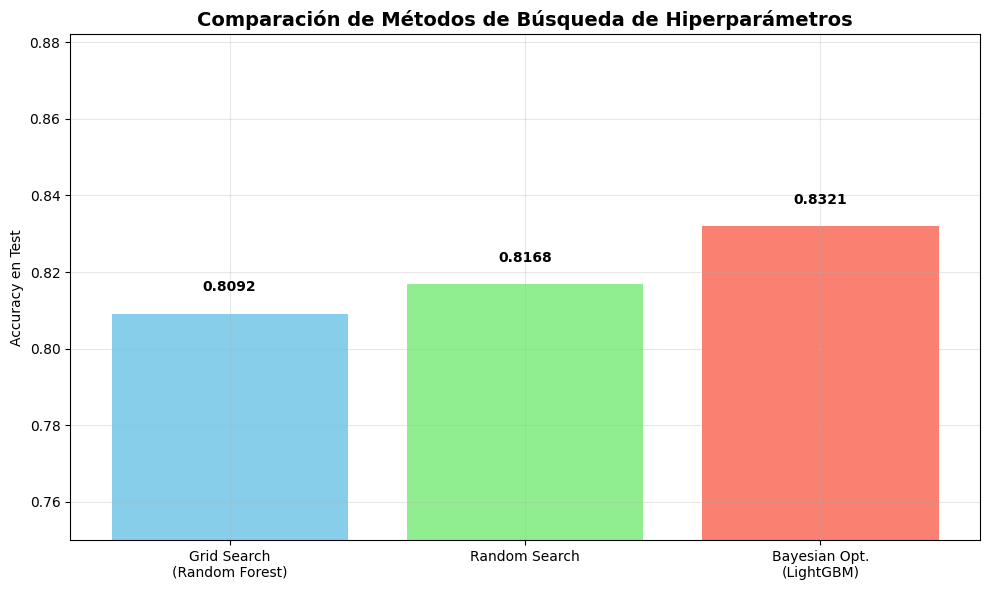

In [ ]:
# -----------------------------------------------------------------------------
# 2.3 OPTIMIZACI√ìN BAYESIANA
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("2.3 OPTIMIZACI√ìN BAYESIANA")
print("-"*30)

if bayesian_available and lightgbm_available:
    print("Optimizaci√≥n Bayesiana usa un modelo probabil√≠stico para guiar la b√∫squeda")
    print("Es m√°s inteligente que Random Search")

    # LightGBM con Optimizaci√≥n Bayesiana
    lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)

    search_spaces = {
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 10),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.7, 1.0),
        'colsample_bytree': Real(0.7, 1.0),
        'num_leaves': Integer(10, 100)
    }

    print("Espacios de b√∫squeda bayesiana:")
    for param, space in search_spaces.items():
        print(f"  {param}: {space}")

    n_calls = 20
    print(f"N√∫mero de evaluaciones: {n_calls}")

    print("Ejecutando Optimizaci√≥n Bayesiana...")
    bayes_search = BayesSearchCV(
        lgb_model, search_spaces, n_iter=n_calls, cv=5,
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    bayes_search.fit(X_train, y_train)

    print(f"Mejores par√°metros: {bayes_search.best_params_}")
    print(f"Mejor score CV: {bayes_search.best_score_:.4f}")

    # Evaluar en test
    y_pred_bayes = bayes_search.predict(X_test)
    accuracy_bayes = accuracy_score(y_test, y_pred_bayes)
    print(f"Accuracy en test: {accuracy_bayes:.4f}")

    best_lgb_bayes = bayes_search.best_estimator_
else:
    print("Optimizaci√≥n Bayesiana no disponible.")
    print("Instala con: pip install scikit-optimize lightgbm")

# Comparar resultados de b√∫squeda
print("\n" + "-"*40)
print("COMPARACI√ìN DE M√âTODOS DE B√öSQUEDA")
print("-"*40)
print(f"Grid Search (Random Forest):     {accuracy_grid:.4f}")
print(f"Random Search:                   {accuracy_random:.4f}")
if bayesian_available and lightgbm_available:
    print(f"Optimizaci√≥n Bayesiana (LightGBM): {accuracy_bayes:.4f}")

# Visualizaci√≥n comparativa de m√©todos de b√∫squeda
search_methods = ['Grid Search\n(Random Forest)', 'Random Search']
search_scores = [accuracy_grid, accuracy_random]

if bayesian_available and lightgbm_available:
    search_methods.append('Bayesian Opt.\n(LightGBM)')
    search_scores.append(accuracy_bayes)

plt.figure(figsize=(10, 6))
bars = plt.bar(search_methods, search_scores, color=['skyblue', 'lightgreen', 'salmon'][:len(search_methods)])
plt.title('Comparaci√≥n de M√©todos de B√∫squeda de Hiperpar√°metros', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy en Test')
plt.ylim(0.75, max(search_scores) + 0.05)

# A√±adir valores en las barras
for bar, score in zip(bars, search_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Regularizaci√≥n y Early Stopping

Tenemos 3 bloques, Regularizaci√≥n L1 (Lasso), Regularizaci√≥n L2 (Ridge) y Early Stopping

In [ ]:
# Escalar datos para regularizaci√≥n
print("Escalando datos para t√©cnicas de regularizaci√≥n...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Escalando datos para t√©cnicas de regularizaci√≥n...



------------------------------
3.1 REGULARIZACI√ìN L1 (LASSO)
------------------------------
L1 (Lasso) penaliza la suma de valores absolutos de los coeficientes
Tiende a hacer que algunos coeficientes sean exactamente 0 (selecci√≥n de caracter√≠sticas)
Probando valores de C (inverso de regularizaci√≥n): [0.01, 0.1, 1, 10, 100]
C m√°s bajo = m√°s regularizaci√≥n

Resultados L1 (Lasso):
C        | Train Acc | Test Acc  | Features Seleccionadas
-------------------------------------------------------
    0.01 |    0.7746 |    0.8015 |                  2
    0.10 |    0.7832 |    0.8168 |                  6
    1.00 |    0.7861 |    0.8206 |                  7
   10.00 |    0.7822 |    0.8206 |                  7
  100.00 |    0.7822 |    0.8206 |                  7

Mejor C para L1: 1 con accuracy test: 0.8206


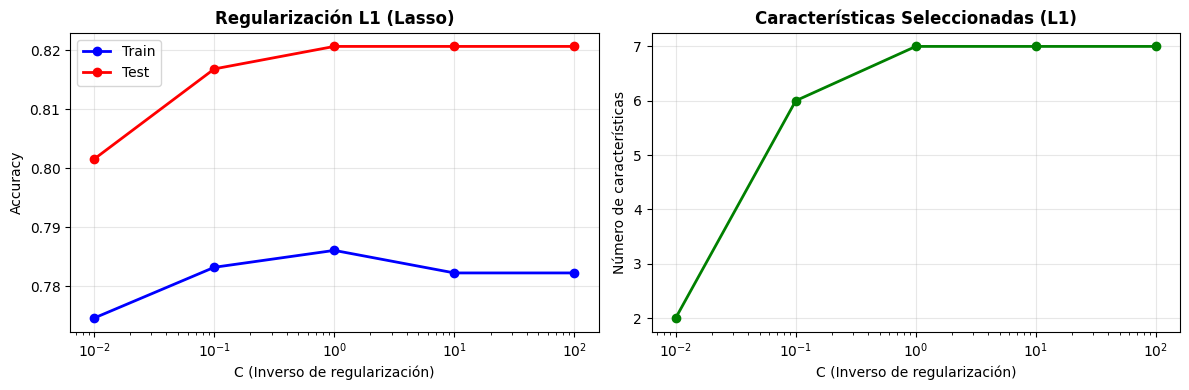

In [ ]:
# -----------------------------------------------------------------------------
# 3.1 REGULARIZACI√ìN L1 (LASSO)
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("3.1 REGULARIZACI√ìN L1 (LASSO)")
print("-"*30)

print("L1 (Lasso) penaliza la suma de valores absolutos de los coeficientes")
print("Tiende a hacer que algunos coeficientes sean exactamente 0 (selecci√≥n de caracter√≠sticas)")

C_values = [0.01, 0.1, 1, 10, 100]
print(f"Probando valores de C (inverso de regularizaci√≥n): {C_values}")
print("C m√°s bajo = m√°s regularizaci√≥n")

print("\nResultados L1 (Lasso):")
print("C        | Train Acc | Test Acc  | Features Seleccionadas")
print("-" * 55)

lasso_results = []
for C in C_values:
    model_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42, max_iter=1000)
    model_l1.fit(X_train_scaled, y_train)

    train_score = model_l1.score(X_train_scaled, y_train)
    test_score = model_l1.score(X_test_scaled, y_test)
    n_features_selected = np.sum(model_l1.coef_[0] != 0)

    lasso_results.append({
        'C': C, 'train_score': train_score, 'test_score': test_score,
        'n_features': n_features_selected
    })

    print(f"{C:8.2f} | {train_score:9.4f} | {test_score:9.4f} | {n_features_selected:18d}")

# Mejor modelo L1
best_l1 = max(lasso_results, key=lambda x: x['test_score'])
print(f"\nMejor C para L1: {best_l1['C']} con accuracy test: {best_l1['test_score']:.4f}")

# Visualizaci√≥n de regularizaci√≥n L1
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
C_vals = [r['C'] for r in lasso_results]
train_scores_l1 = [r['train_score'] for r in lasso_results]
test_scores_l1 = [r['test_score'] for r in lasso_results]

plt.semilogx(C_vals, train_scores_l1, 'o-', label='Train', color='blue', linewidth=2)
plt.semilogx(C_vals, test_scores_l1, 'o-', label='Test', color='red', linewidth=2)
plt.title('Regularizaci√≥n L1 (Lasso)', fontweight='bold')
plt.xlabel('C (Inverso de regularizaci√≥n)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
n_features = [r['n_features'] for r in lasso_results]
plt.semilogx(C_vals, n_features, 'o-', color='green', linewidth=2)
plt.title('Caracter√≠sticas Seleccionadas (L1)', fontweight='bold')
plt.xlabel('C (Inverso de regularizaci√≥n)')
plt.ylabel('N√∫mero de caracter√≠sticas')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



------------------------------
3.2 REGULARIZACI√ìN L2 (RIDGE)
------------------------------
L2 (Ridge) penaliza la suma de cuadrados de los coeficientes
Tiende a reducir los coeficientes pero no los hace exactamente 0

Resultados L2 (Ridge):
C        | Train Acc | Test Acc  | Norma L2 Coeficientes
-------------------------------------------------------
    0.01 |    0.7880 |    0.8359 |            0.8896
    0.10 |    0.7841 |    0.8168 |            1.4094
    1.00 |    0.7841 |    0.8206 |            1.5397
   10.00 |    0.7822 |    0.8206 |            1.5553
  100.00 |    0.7822 |    0.8206 |            1.5569

Mejor C para L2: 0.01 con accuracy test: 0.8359


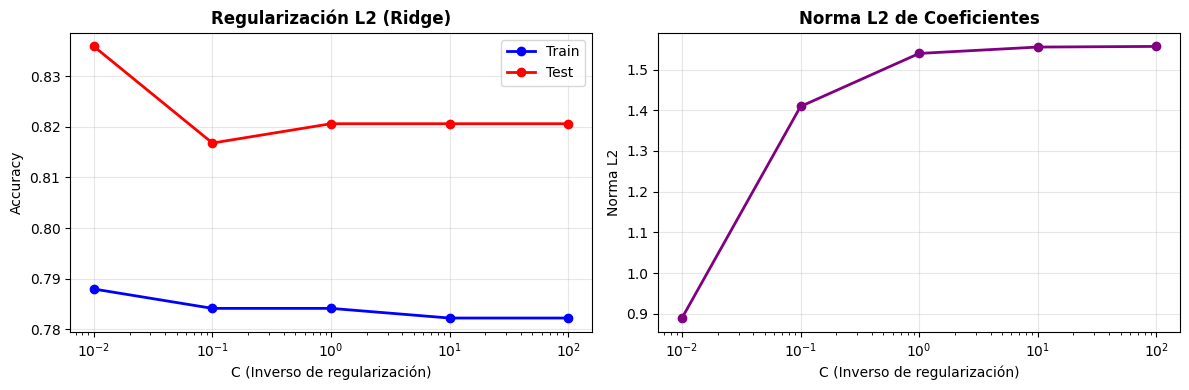

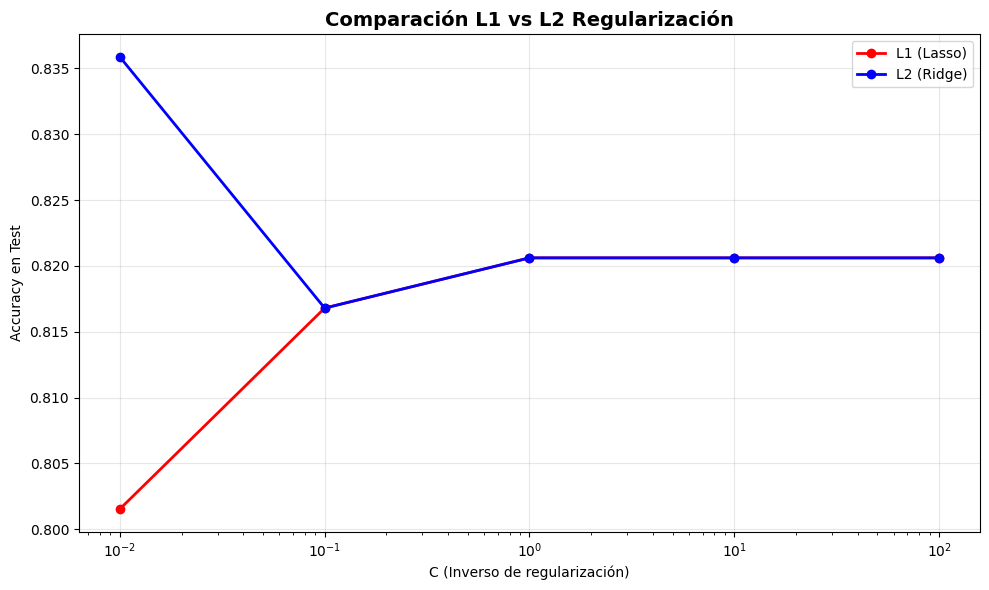

In [ ]:
# -----------------------------------------------------------------------------
# 3.2 REGULARIZACI√ìN L2 (RIDGE)
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("3.2 REGULARIZACI√ìN L2 (RIDGE)")
print("-"*30)

print("L2 (Ridge) penaliza la suma de cuadrados de los coeficientes")
print("Tiende a reducir los coeficientes pero no los hace exactamente 0")

print("\nResultados L2 (Ridge):")
print("C        | Train Acc | Test Acc  | Norma L2 Coeficientes")
print("-" * 55)

ridge_results = []
for C in C_values:
    model_l2 = LogisticRegression(penalty='l2', C=C, random_state=42, max_iter=1000)
    model_l2.fit(X_train_scaled, y_train)

    train_score = model_l2.score(X_train_scaled, y_train)
    test_score = model_l2.score(X_test_scaled, y_test)
    l2_norm = np.linalg.norm(model_l2.coef_)

    ridge_results.append({
        'C': C, 'train_score': train_score, 'test_score': test_score,
        'l2_norm': l2_norm
    })

    print(f"{C:8.2f} | {train_score:9.4f} | {test_score:9.4f} | {l2_norm:17.4f}")

# Mejor modelo L2
best_l2 = max(ridge_results, key=lambda x: x['test_score'])
print(f"\nMejor C para L2: {best_l2['C']} con accuracy test: {best_l2['test_score']:.4f}")

# Visualizaci√≥n de regularizaci√≥n L2
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
C_vals = [r['C'] for r in ridge_results]
train_scores_l2 = [r['train_score'] for r in ridge_results]
test_scores_l2 = [r['test_score'] for r in ridge_results]

plt.semilogx(C_vals, train_scores_l2, 'o-', label='Train', color='blue', linewidth=2)
plt.semilogx(C_vals, test_scores_l2, 'o-', label='Test', color='red', linewidth=2)
plt.title('Regularizaci√≥n L2 (Ridge)', fontweight='bold')
plt.xlabel('C (Inverso de regularizaci√≥n)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
l2_norms = [r['l2_norm'] for r in ridge_results]
plt.semilogx(C_vals, l2_norms, 'o-', color='purple', linewidth=2)
plt.title('Norma L2 de Coeficientes', fontweight='bold')
plt.xlabel('C (Inverso de regularizaci√≥n)')
plt.ylabel('Norma L2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparaci√≥n L1 vs L2
plt.figure(figsize=(10, 6))
plt.semilogx(C_vals, test_scores_l1, 'o-', label='L1 (Lasso)', color='red', linewidth=2)
plt.semilogx(C_vals, test_scores_l2, 'o-', label='L2 (Ridge)', color='blue', linewidth=2)
plt.title('Comparaci√≥n L1 vs L2 Regularizaci√≥n', fontsize=14, fontweight='bold')
plt.xlabel('C (Inverso de regularizaci√≥n)')
plt.ylabel('Accuracy en Test')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# 3.3 EARLY STOPPING
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("3.3 EARLY STOPPING")
print("-"*30)

print("Early Stopping detiene el entrenamiento cuando la mejora se estanca")
print("Evita overfitting en modelos iterativos")

if xgboost_available:
    # Dividir training en train y validation para early stopping
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Dividiendo training en: {X_tr.shape[0]} train, {X_val.shape[0]} validaci√≥n")

    # XGBoost con early stopping
    print("\nEntrenando XGBoost con early stopping...")
    model_es = xgb.XGBClassifier(
        n_estimators=1000,  # N√∫mero alto
        learning_rate=0.1,
        random_state=42,
        early_stopping_rounds=10,  # Parar si no mejora en 10 rondas
        eval_metric='logloss'
    )

    model_es.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    print(f"N√∫mero √≥ptimo de estimadores (early stopping): {model_es.best_iteration}")
    print(f"Mejor score de validaci√≥n: {model_es.best_score:.4f}")

    # Evaluar en test
    test_score_es = model_es.score(X_test, y_test)
    print(f"Accuracy en test con early stopping: {test_score_es:.4f}")

    # Comparar con modelo sin early stopping
    print("\nComparando con modelo sin early stopping...")
    model_no_es = xgb.XGBClassifier(
        n_estimators=1000,  # Mismo n√∫mero alto
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    model_no_es.fit(X_tr, y_tr)
    test_score_no_es = model_no_es.score(X_test, y_test)

    print(f"Sin early stopping - Accuracy test: {test_score_no_es:.4f}")
    print(f"Diferencia (ES - No ES): {test_score_es - test_score_no_es:.4f}")

    if test_score_es > test_score_no_es:
        print("‚úÖ Early stopping mejor√≥ el rendimiento")
    else:
        print("‚ö†Ô∏è Early stopping no mejor√≥ el rendimiento en este caso")
else:
    print("XGBoost no disponible para demostrar Early Stopping")
    print("Se puede usar con GradientBoostingClassifier tambi√©n")


------------------------------
3.3 EARLY STOPPING
------------------------------
Early Stopping detiene el entrenamiento cuando la mejora se estanca
Evita overfitting en modelos iterativos
Dividiendo training en: 837 train, 210 validaci√≥n

Entrenando XGBoost con early stopping...
N√∫mero √≥ptimo de estimadores (early stopping): 24
Mejor score de validaci√≥n: 0.4531
Accuracy en test con early stopping: 0.8130

Comparando con modelo sin early stopping...
Sin early stopping - Accuracy test: 0.7901
Diferencia (ES - No ES): 0.0229
‚úÖ Early stopping mejor√≥ el rendimiento


### Validaci√≥n y Deteccion de Overfitting

Tenemos 3 bloques, Validaci√≥n cruzada estandar y Validaci√≥n cruzada estratificada


------------------------------
4.1 VALIDACI√ìN CRUZADA EST√ÅNDAR
------------------------------
Validaci√≥n cruzada divide los datos en k partes y entrena k veces
Cada vez usa k-1 partes para entrenar y 1 para validar
Comparando 5 modelos con validaci√≥n cruzada de 5 folds...

Resultados de Validaci√≥n Cruzada:
Modelo               | Media    | Std     | Min     | Max
------------------------------------------------------------
Decision Tree        | 0.6562 | 0.0870 | 0.4962 | 0.7595
Random Forest        | 0.6493 | 0.0781 | 0.5038 | 0.7328
Gradient Boosting    | 0.6860 | 0.1052 | 0.5153 | 0.8397
XGBoost              | 0.6631 | 0.0853 | 0.5076 | 0.7634
LightGBM             | 0.6639 | 0.0844 | 0.5115 | 0.7634

Mejor modelo por CV: Gradient Boosting (0.6860 ¬± 0.1052)


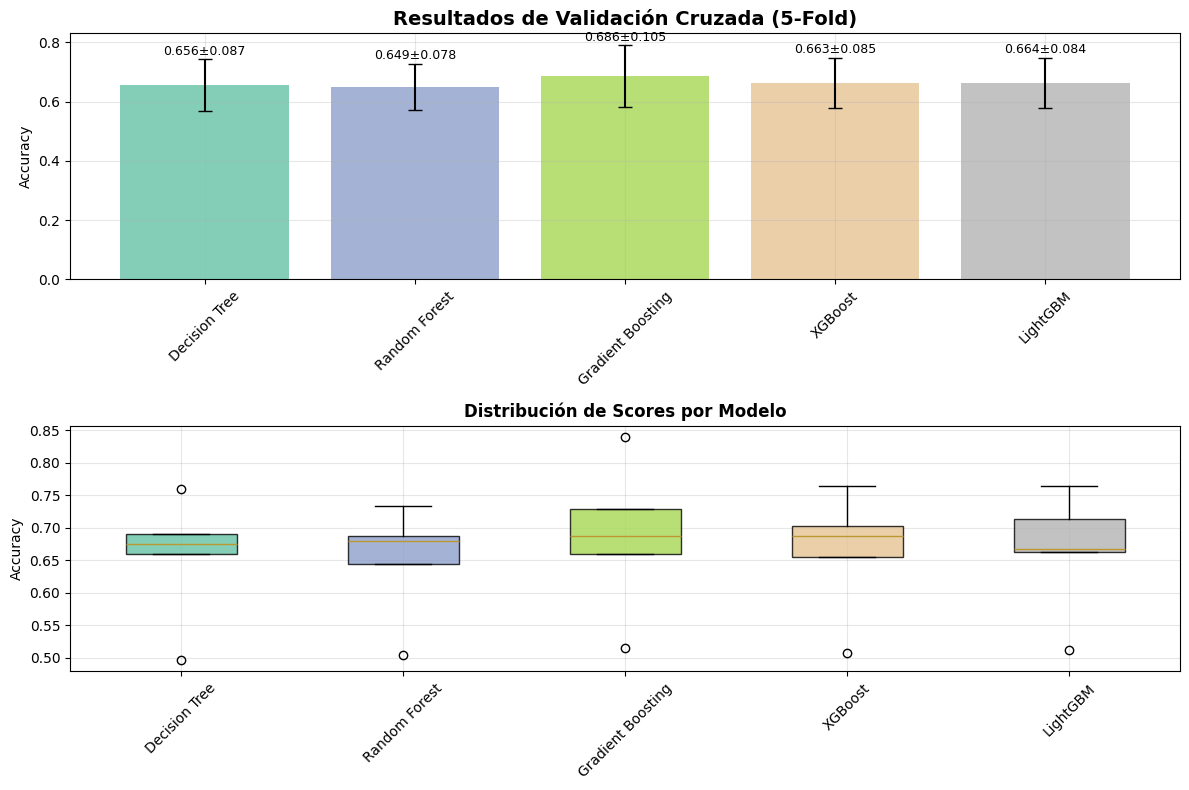

In [ ]:
# -----------------------------------------------------------------------------
# 4.1 VALIDACI√ìN CRUZADA EST√ÅNDAR
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("4.1 VALIDACI√ìN CRUZADA EST√ÅNDAR")
print("-"*30)

print("Validaci√≥n cruzada divide los datos en k partes y entrena k veces")
print("Cada vez usa k-1 partes para entrenar y 1 para validar")

# Definir modelos a comparar
modelos = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

if xgboost_available:
    modelos['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

if lightgbm_available:
    modelos['LightGBM'] = lgb.LGBMClassifier(random_state=42, verbose=-1)

print(f"Comparando {len(modelos)} modelos con validaci√≥n cruzada de 5 folds...")

print("\nResultados de Validaci√≥n Cruzada:")
print("Modelo               | Media    | Std     | Min     | Max")
print("-" * 60)

cv_results = {}
for name, model in modelos.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max(),
        'scores': scores
    }

    print(f"{name:20s} | {scores.mean():.4f} | {scores.std():.4f} | {scores.min():.4f} | {scores.max():.4f}")

# Mejor modelo
best_model = max(cv_results.keys(), key=lambda x: cv_results[x]['mean'])
print(f"\nMejor modelo por CV: {best_model} ({cv_results[best_model]['mean']:.4f} ¬± {cv_results[best_model]['std']:.4f})")

# Visualizaci√≥n de resultados de validaci√≥n cruzada
plt.figure(figsize=(12, 8))

# Gr√°fico de barras con barras de error
model_names = list(cv_results.keys())
means = [cv_results[name]['mean'] for name in model_names]
stds = [cv_results[name]['std'] for name in model_names]

colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))

plt.subplot(2, 1, 1)
bars = plt.bar(model_names, means, yerr=stds, capsize=5, color=colors, alpha=0.8)
plt.title('Resultados de Validaci√≥n Cruzada (5-Fold)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# A√±adir valores en las barras
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.005,
             f'{mean:.3f}¬±{std:.3f}', ha='center', va='bottom', fontsize=9)

# Box plot de los scores
plt.subplot(2, 1, 2)
scores_data = [cv_results[name]['scores'] for name in model_names]
box_plot = plt.boxplot(scores_data, labels=model_names, patch_artist=True)

# Colorear las cajas
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

plt.title('Distribuci√≥n de Scores por Modelo', fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


------------------------------
4.2 VALIDACI√ìN CRUZADA ESTRATIFICADA
------------------------------
Stratified CV mantiene la proporci√≥n de clases en cada fold
Importante para datasets desbalanceados
Distribuci√≥n original del target:
  Clase 0: 0.618
  Clase 1: 0.382

Usando StratifiedKFold con 5 splits...
Verificando proporciones por fold:
Fold | Clase 0 | Clase 1
-------------------------
   1 |   0.618 |   0.382
   2 |   0.618 |   0.382
   3 |   0.618 |   0.382
   4 |   0.618 |   0.382
   5 |   0.617 |   0.383
Desviaci√≥n est√°ndar entre folds:
  Clase 0: 0.0006
  Clase 1: 0.0006

Random Forest con Stratified CV:
Scores por fold: [0.75954198 0.80534351 0.77862595 0.82442748 0.77777778]
Media: 0.7891 (+/- 0.0458)


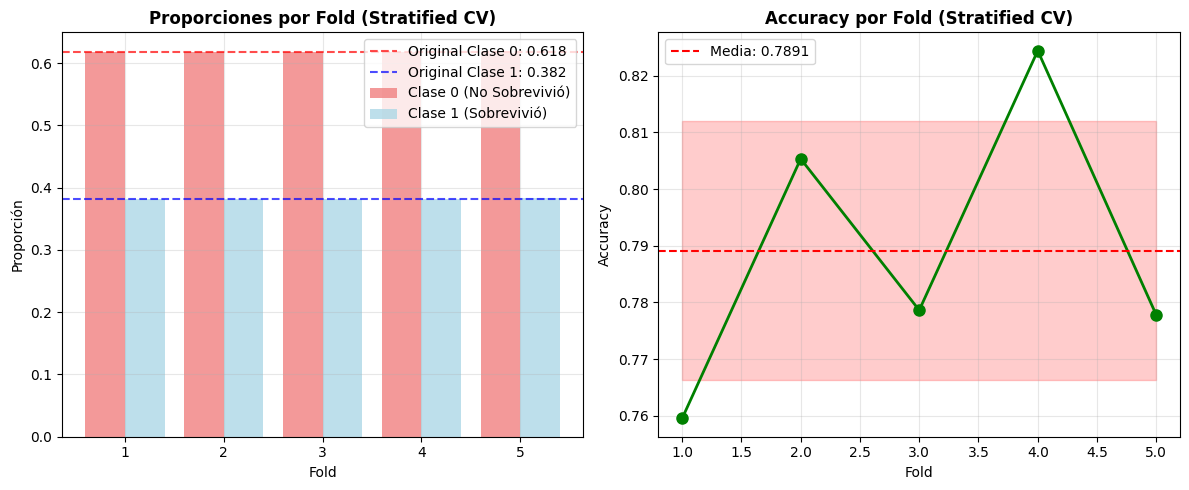

In [ ]:
# -----------------------------------------------------------------------------
# 4.2 VALIDACI√ìN CRUZADA ESTRATIFICADA
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("4.2 VALIDACI√ìN CRUZADA ESTRATIFICADA")
print("-"*30)

print("Stratified CV mantiene la proporci√≥n de clases en cada fold")
print("Importante para datasets desbalanceados")

print("Distribuci√≥n original del target:")
target_dist = y.value_counts(normalize=True)
for class_val, prop in target_dist.items():
    print(f"  Clase {class_val}: {prop:.3f}")

# Usar StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nUsando StratifiedKFold con {skf.n_splits} splits...")

# Verificar que cada fold mantiene la proporci√≥n
print("Verificando proporciones por fold:")
print("Fold | Clase 0 | Clase 1")
print("-" * 25)

fold_proportions = []
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    fold_y = y.iloc[test_idx]
    prop_0 = (fold_y == 0).mean()
    prop_1 = (fold_y == 1).mean()
    fold_proportions.append([prop_0, prop_1])
    print(f"{i+1:4d} | {prop_0:7.3f} | {prop_1:7.3f}")

print(f"Desviaci√≥n est√°ndar entre folds:")
fold_props_array = np.array(fold_proportions)
print(f"  Clase 0: {fold_props_array[:, 0].std():.4f}")
print(f"  Clase 1: {fold_props_array[:, 1].std():.4f}")

# Aplicar a Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
stratified_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='accuracy')

print(f"\nRandom Forest con Stratified CV:")
print(f"Scores por fold: {stratified_scores}")
print(f"Media: {stratified_scores.mean():.4f} (+/- {stratified_scores.std() * 2:.4f})")

# Visualizaci√≥n de Stratified CV
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Proporciones por fold
fold_props_array = np.array(fold_proportions)
folds = range(1, len(fold_proportions) + 1)

plt.bar([f - 0.2 for f in folds], fold_props_array[:, 0], 0.4,
        label='Clase 0 (No Sobrevivi√≥)', color='lightcoral', alpha=0.8)
plt.bar([f + 0.2 for f in folds], fold_props_array[:, 1], 0.4,
        label='Clase 1 (Sobrevivi√≥)', color='lightblue', alpha=0.8)

plt.axhline(y=target_dist[0], color='red', linestyle='--', alpha=0.7,
           label=f'Original Clase 0: {target_dist[0]:.3f}')
plt.axhline(y=target_dist[1], color='blue', linestyle='--', alpha=0.7,
           label=f'Original Clase 1: {target_dist[1]:.3f}')

plt.title('Proporciones por Fold (Stratified CV)', fontweight='bold')
plt.xlabel('Fold')
plt.ylabel('Proporci√≥n')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Scores por fold
plt.plot(folds, stratified_scores, 'o-', color='green', linewidth=2, markersize=8)
plt.axhline(y=stratified_scores.mean(), color='red', linestyle='--',
           label=f'Media: {stratified_scores.mean():.4f}')
plt.fill_between(folds,
                stratified_scores.mean() - stratified_scores.std(),
                stratified_scores.mean() + stratified_scores.std(),
                alpha=0.2, color='red')

plt.title('Accuracy por Fold (Stratified CV)', fontweight='bold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


------------------------------
4.3 DETECCI√ìN DE OVERFITTING
------------------------------
Overfitting ocurre cuando el modelo memoriza los datos de entrenamiento
Se detecta comparando performance en train vs validaci√≥n

An√°lisis de Overfitting usando Learning Curves:
Modelo                     | Train Final | Val Final | Gap     | Overfitting
--------------------------------------------------------------------------------
Decision Tree (Profundo)   |      0.9694 |    0.6562 |  0.3132 | ‚ö†Ô∏è  S√ç
Decision Tree (Limitado)   |      0.8395 |    0.6799 |  0.1597 | ‚ö†Ô∏è  S√ç
Random Forest (200 √°rboles) |      0.9694 |    0.6486 |  0.3209 | ‚ö†Ô∏è  S√ç
Random Forest (20 √°rboles) |      0.9635 |    0.6478 |  0.3157 | ‚ö†Ô∏è  S√ç


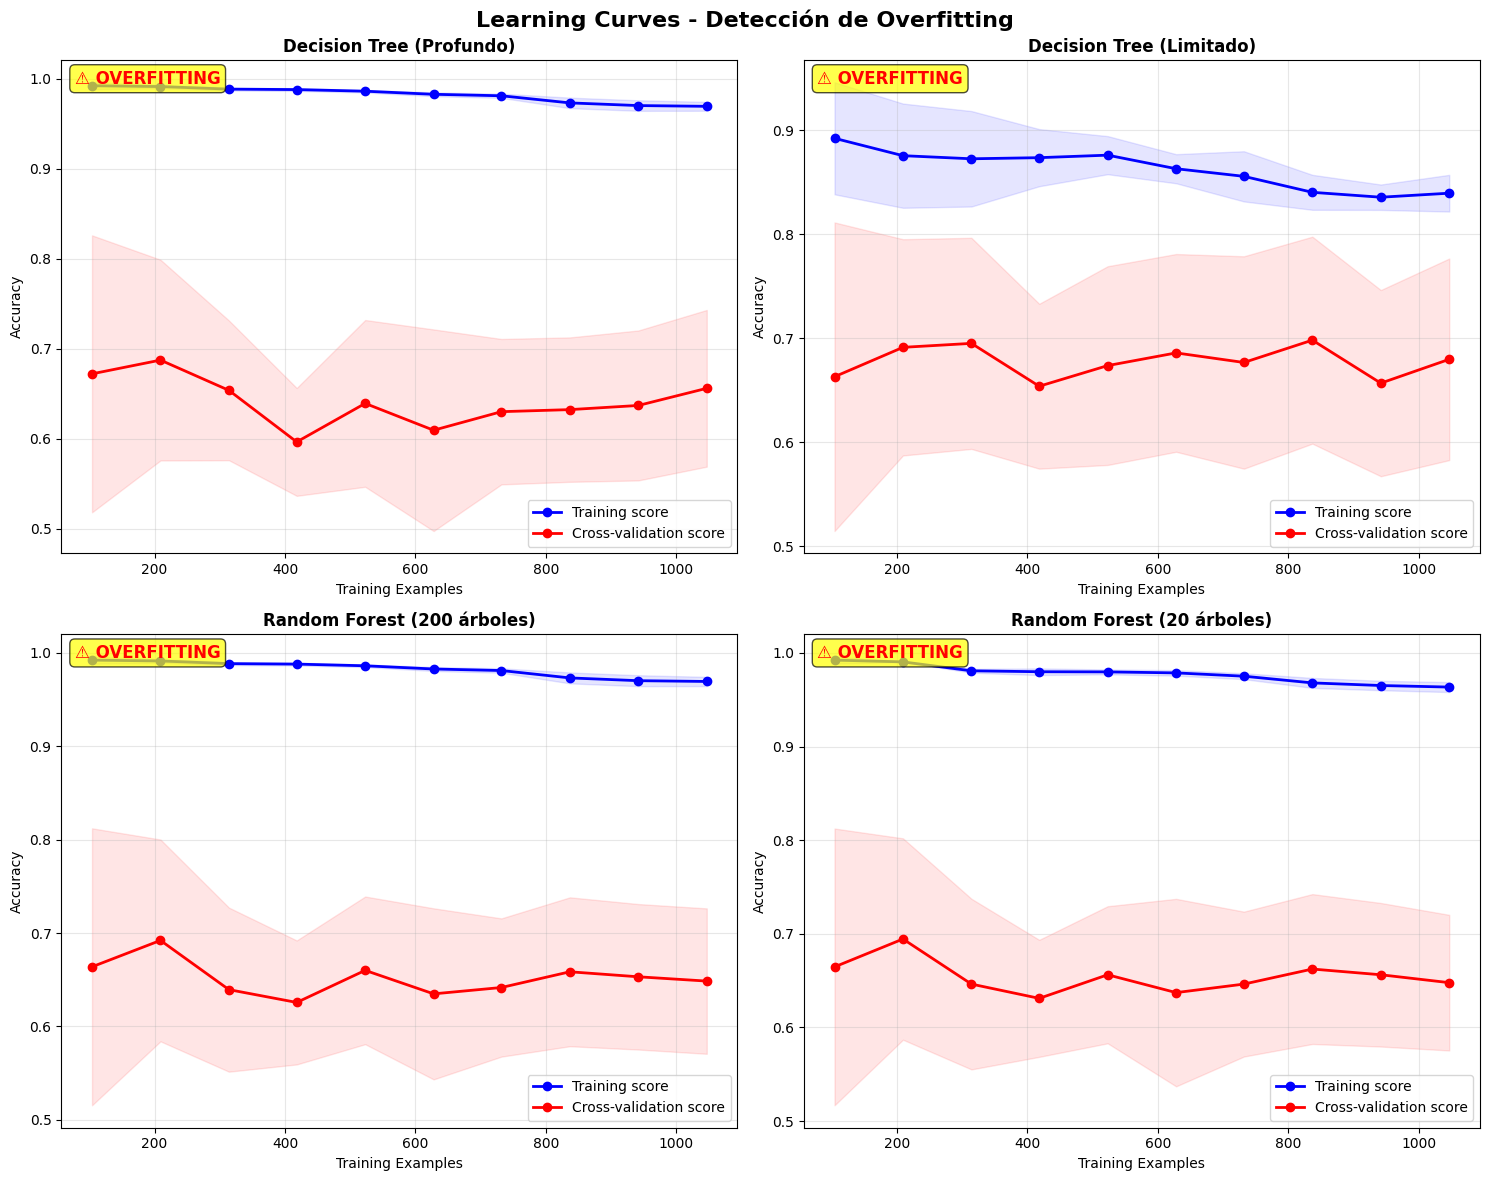

In [ ]:
# -----------------------------------------------------------------------------
# 4.3 DETECCI√ìN DE OVERFITTING
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("4.3 DETECCI√ìN DE OVERFITTING")
print("-"*30)

print("Overfitting ocurre cuando el modelo memoriza los datos de entrenamiento")
print("Se detecta comparando performance en train vs validaci√≥n")

# Comparar modelos con diferentes complejidades
modelos_complexity = {
    'Decision Tree (Profundo)': DecisionTreeClassifier(max_depth=None, random_state=42),
    'Decision Tree (Limitado)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest (200 √°rboles)': RandomForestClassifier(n_estimators=200, random_state=42),
    'Random Forest (20 √°rboles)': RandomForestClassifier(n_estimators=20, random_state=42)
}

print("\nAn√°lisis de Overfitting usando Learning Curves:")
print("Modelo                     | Train Final | Val Final | Gap     | Overfitting")
print("-" * 80)

learning_curve_data = {}

for name, model in modelos_complexity.items():
    # Curva de aprendizaje
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    # Guardar datos para visualizaci√≥n
    learning_curve_data[name] = {
        'train_sizes': train_sizes,
        'train_mean': train_mean,
        'train_std': train_std,
        'val_mean': val_mean,
        'val_std': val_std
    }

    # Analizar overfitting en el punto final
    final_train = train_mean[-1]
    final_val = val_mean[-1]
    gap = final_train - final_val

    # Determinar si hay overfitting
    if gap > 0.05:
        overfitting_status = "‚ö†Ô∏è  S√ç"
    elif gap > 0.02:
        overfitting_status = "‚ö° Leve"
    else:
        overfitting_status = "‚úÖ NO"

    print(f"{name:26s} | {final_train:11.4f} | {final_val:9.4f} | {gap:7.4f} | {overfitting_status}")

# Visualizaci√≥n de Learning Curves
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, data) in enumerate(learning_curve_data.items()):
    ax = axes[idx]

    # Plotear curvas de aprendizaje
    ax.plot(data['train_sizes'], data['train_mean'], 'o-', color='blue',
            label='Training score', linewidth=2)
    ax.fill_between(data['train_sizes'],
                    data['train_mean'] - data['train_std'],
                    data['train_mean'] + data['train_std'],
                    alpha=0.1, color='blue')

    ax.plot(data['train_sizes'], data['val_mean'], 'o-', color='red',
            label='Cross-validation score', linewidth=2)
    ax.fill_between(data['train_sizes'],
                    data['val_mean'] - data['val_std'],
                    data['val_mean'] + data['val_std'],
                    alpha=0.1, color='red')

    ax.set_title(f'{name}', fontweight='bold')
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

    # Destacar overfitting
    final_gap = data['train_mean'][-1] - data['val_mean'][-1]
    if final_gap > 0.05:
        ax.text(0.02, 0.98, '‚ö†Ô∏è OVERFITTING', transform=ax.transAxes,
                fontsize=12, fontweight='bold', color='red',
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.suptitle('Learning Curves - Detecci√≥n de Overfitting', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


------------------------------
4.4 CURVAS DE VALIDACI√ìN
------------------------------
Las curvas de validaci√≥n muestran c√≥mo cambia el rendimiento
al variar un hiperpar√°metro espec√≠fico
Analizando n_estimators en Random Forest: [10, 20, 50, 100, 200, 300]
Calculando curvas de validaci√≥n...

Resultados de Curva de Validaci√≥n:
n_estimators | Train Score (¬±std) | Val Score (¬±std)   | Gap     | Status
---------------------------------------------------------------------------
         10 | 0.9578 (¬±0.006) | 0.6409 (¬±0.071) |  0.3168 | ‚ö†Ô∏è Overfitting
         20 | 0.9631 (¬±0.005) | 0.6486 (¬±0.072) |  0.3146 | ‚ö†Ô∏è Overfitting
         50 | 0.9685 (¬±0.005) | 0.6471 (¬±0.077) |  0.3214 | ‚ö†Ô∏è Overfitting
        100 | 0.9694 (¬±0.005) | 0.6493 (¬±0.078) |  0.3201 | ‚ö†Ô∏è Overfitting
        200 | 0.9694 (¬±0.005) | 0.6478 (¬±0.078) |  0.3216 | ‚ö†Ô∏è Overfitting
        300 | 0.9694 (¬±0.005) | 0.6470 (¬±0.080) |  0.3224 | ‚ö†Ô∏è Overfitting

Mejor n_estimators: 100 (

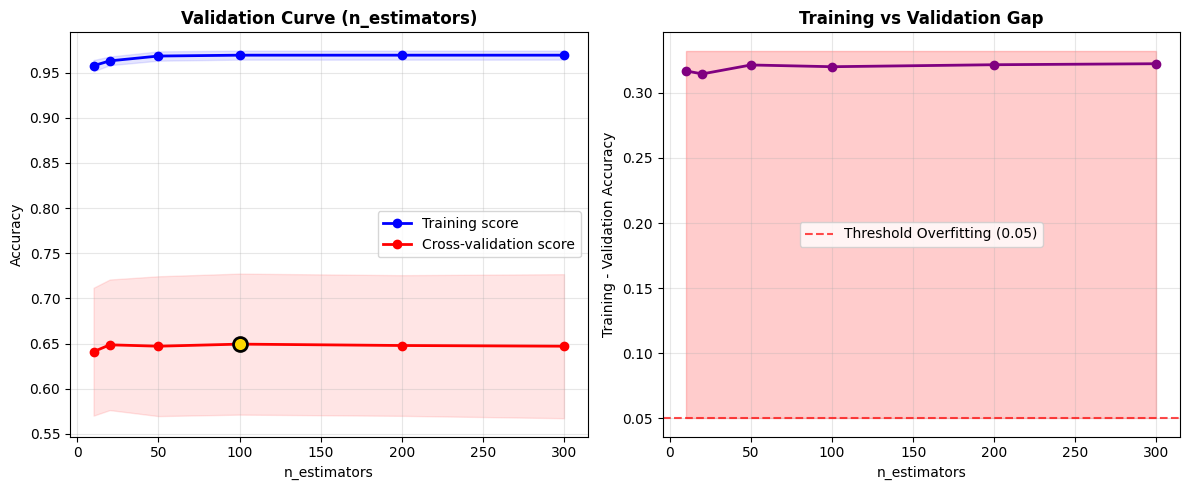

In [ ]:
# -----------------------------------------------------------------------------
# 4.4 CURVAS DE VALIDACI√ìN
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("4.4 CURVAS DE VALIDACI√ìN")
print("-"*30)

print("Las curvas de validaci√≥n muestran c√≥mo cambia el rendimiento")
print("al variar un hiperpar√°metro espec√≠fico")

# Ejemplo con Random Forest y n_estimators
param_range = [10, 20, 50, 100, 200, 300]
print(f"Analizando n_estimators en Random Forest: {param_range}")

print("Calculando curvas de validaci√≥n...")
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X, y, param_name='n_estimators', param_range=param_range,
    cv=5, scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

print("\nResultados de Curva de Validaci√≥n:")
print("n_estimators | Train Score (¬±std) | Val Score (¬±std)   | Gap     | Status")
print("-" * 75)

for i, n_est in enumerate(param_range):
    gap = train_mean[i] - val_mean[i]
    if gap > 0.05:
        status = "‚ö†Ô∏è Overfitting"
    elif gap < -0.02:
        status = "‚ö° Underfitting"
    else:
        status = "‚úÖ Balanced"

    print(f"{n_est:11d} | {train_mean[i]:6.4f} (¬±{train_std[i]:.3f}) | {val_mean[i]:6.4f} (¬±{val_std[i]:.3f}) | {gap:7.4f} | {status}")

# Encontrar el mejor par√°metro
best_idx = np.argmax(val_mean)
best_n_estimators = param_range[best_idx]
print(f"\nMejor n_estimators: {best_n_estimators} (Val accuracy: {val_mean[best_idx]:.4f})")

# Visualizaci√≥n de curvas de validaci√≥n
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(param_range, train_mean, 'o-', color='blue', label='Training score', linewidth=2)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(param_range, val_mean, 'o-', color='red', label='Cross-validation score', linewidth=2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title('Validation Curve (n_estimators)', fontweight='bold')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Marcar el mejor punto
plt.scatter(best_n_estimators, val_mean[best_idx], color='gold', s=100, zorder=5,
           edgecolors='black', linewidth=2, label=f'Best: {best_n_estimators}')

plt.subplot(1, 2, 2)
# Gap entre training y validation
gap = train_mean - val_mean
plt.plot(param_range, gap, 'o-', color='purple', linewidth=2)
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Threshold Overfitting (0.05)')
plt.title('Training vs Validation Gap', fontweight='bold')
plt.xlabel('n_estimators')
plt.ylabel('Training - Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Sombrear zona de overfitting
plt.fill_between(param_range, 0.05, max(gap) + 0.01, alpha=0.2, color='red', label='Overfitting Zone')

plt.tight_layout()
plt.show()

### Metricas de evaluaci√≥n de los modelos



In [ ]:
# -----------------------------------------------------------------------------
# 5.1 M√âTRICAS COMPLETAS
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("5.1 M√âTRICAS COMPLETAS")
print("-"*30)

print("Entrenando modelos finales para evaluaci√≥n completa...")

# Entrenar modelos con mejores hiperpar√°metros encontrados
final_models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=best_n_estimators, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

if xgboost_available:
    final_models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')

if lightgbm_available:
    final_models['LightGBM'] = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

print("\nM√©tricas de Evaluaci√≥n por Modelo:")
print("=" * 60)

metrics_results = {}

for name, model in final_models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Obtener probabilidades para ROC-AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None

    # Calcular m√©tricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    else:
        metrics['roc_auc'] = None

    metrics_results[name] = metrics

    print(f"{name} - M√©tricas:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    if metrics['roc_auc'] is not None:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    else:
        print(f"  ROC-AUC:   No disponible")

# Comparaci√≥n final
print("\n" + "-"*60)
print("TABLA COMPARATIVA DE M√âTRICAS")
print("-"*60)
print("Modelo           | Accuracy | Precision | Recall  | F1-Score | ROC-AUC")
print("-" * 70)

for name, metrics in metrics_results.items():
    roc_str = f"{metrics['roc_auc']:.4f}" if metrics['roc_auc'] is not None else "  N/A  "
    print(f"{name:15s} | {metrics['accuracy']:8.4f} | {metrics['precision']:9.4f} | {metrics['recall']:7.4f} | {metrics['f1']:8.4f} | {roc_str}")



------------------------------
5.1 M√âTRICAS COMPLETAS
------------------------------
Entrenando modelos finales para evaluaci√≥n completa...

M√©tricas de Evaluaci√≥n por Modelo:

Entrenando Decision Tree...
Decision Tree - M√©tricas:
  Accuracy:  0.8282
  Precision: 0.8571
  Recall:    0.6600
  F1-Score:  0.7458
  ROC-AUC:   0.8726

Entrenando Random Forest...
Random Forest - M√©tricas:
  Accuracy:  0.7824
  Precision: 0.7129
  Recall:    0.7200
  F1-Score:  0.7164
  ROC-AUC:   0.8590

Entrenando Gradient Boosting...
Gradient Boosting - M√©tricas:
  Accuracy:  0.8130
  Precision: 0.7931
  Recall:    0.6900
  F1-Score:  0.7380
  ROC-AUC:   0.8849

Entrenando XGBoost...
XGBoost - M√©tricas:
  Accuracy:  0.7977
  Precision: 0.7423
  Recall:    0.7200
  F1-Score:  0.7310
  ROC-AUC:   0.8723

Entrenando LightGBM...
LightGBM - M√©tricas:
  Accuracy:  0.8244
  Precision: 0.7755
  Recall:    0.7600
  F1-Score:  0.7677
  ROC-AUC:   0.8866

----------------------------------------------------

In [ ]:
# -----------------------------------------------------------------------------
# 5.2 MATRIZ DE CONFUSI√ìN DETALLADA
# -----------------------------------------------------------------------------
print("\n" + "-"*40)
print("5.2 AN√ÅLISIS DE MATRIZ DE CONFUSI√ìN")
print("-"*40)

# Usar el mejor modelo para an√°lisis detallado
best_model_name = max(metrics_results.keys(), key=lambda x: metrics_results[x]['accuracy'])
best_model = final_models[best_model_name]

print(f"Analizando matriz de confusi√≥n para: {best_model_name}")
print(f"(Mejor modelo por accuracy: {metrics_results[best_model_name]['accuracy']:.4f})")

# Entrenar si no est√° entrenado
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_best)

print("\nMatriz de Confusi√≥n:")
print("                    Predicho")
print("                 No Sobr. | Sobr.")
print("              +----------+----------+")
print(f"Real No Sobr. |   {cm[0,0]:4d}   |   {cm[0,1]:4d}   |")
print("              +----------+----------+")
print(f"     Sobr.    |   {cm[1,0]:4d}   |   {cm[1,1]:4d}   |")
print("              +----------+----------+")

# Desglose de la matriz
tn, fp, fn, tp = cm.ravel()

print(f"\nDesglose de Predicciones:")
print(f"  Verdaderos Negativos (TN): {tn} - Correctamente predijo 'No Sobrevivi√≥'")
print(f"  Falsos Positivos (FP):     {fp} - Incorrectamente predijo 'Sobrevivi√≥'")
print(f"  Falsos Negativos (FN):     {fn} - Incorrectamente predijo 'No Sobrevivi√≥'")
print(f"  Verdaderos Positivos (TP): {tp} - Correctamente predijo 'Sobrevivi√≥'")

# M√©tricas calculadas manualmente desde la matriz
accuracy_manual = (tp + tn) / (tp + tn + fp + fn)
precision_manual = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_manual = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual) if (precision_manual + recall_manual) > 0 else 0

print(f"\nM√©tricas Calculadas desde la Matriz:")
print(f"  Accuracy =    (TP + TN) / Total           = ({tp} + {tn}) / {tp + tn + fp + fn} = {accuracy_manual:.4f}")
print(f"  Precision =   TP / (TP + FP)              = {tp} / ({tp} + {fp}) = {precision_manual:.4f}")
print(f"  Recall =      TP / (TP + FN)              = {tp} / ({tp} + {fn}) = {recall_manual:.4f}")
print(f"  Specificity = TN / (TN + FP)              = {tn} / ({tn} + {fp}) = {specificity:.4f}")
print(f"  F1-Score =    2 * (Prec * Rec)/(Prec+Rec) = 2 * ({precision_manual:.4f} * {recall_manual:.4f})/({precision_manual:.4f}+{recall_manual:.4f}) = {f1_manual:.4f}")


----------------------------------------
5.2 AN√ÅLISIS DE MATRIZ DE CONFUSI√ìN
----------------------------------------
Analizando matriz de confusi√≥n para: Decision Tree
(Mejor modelo por accuracy: 0.8282)

Matriz de Confusi√≥n:
                    Predicho
                 No Sobr. | Sobr.
              +----------+----------+
Real No Sobr. |    151   |     11   |
              +----------+----------+
     Sobr.    |     34   |     66   |
              +----------+----------+

Desglose de Predicciones:
  Verdaderos Negativos (TN): 151 - Correctamente predijo 'No Sobrevivi√≥'
  Falsos Positivos (FP):     11 - Incorrectamente predijo 'Sobrevivi√≥'
  Falsos Negativos (FN):     34 - Incorrectamente predijo 'No Sobrevivi√≥'
  Verdaderos Positivos (TP): 66 - Correctamente predijo 'Sobrevivi√≥'

M√©tricas Calculadas desde la Matriz:
  Accuracy =    (TP + TN) / Total           = (66 + 151) / 262 = 0.8282
  Precision =   TP / (TP + FP)              = 66 / (66 + 11) = 0.8571
  Recall =      

In [ ]:
# -----------------------------------------------------------------------------
# 5.3 REPORTE DE CLASIFICACI√ìN COMPLETO
# -----------------------------------------------------------------------------
print("\n" + "-"*40)
print("5.3 REPORTE DE CLASIFICACI√ìN COMPLETO")
print("-"*40)

# Reporte detallado con nombres de clases
class_names = ['No Sobrevivi√≥', 'Sobrevivi√≥']
report = classification_report(y_test, y_pred_best, target_names=class_names)
print(report)

print("\nüìä INTERPRETACI√ìN DE M√âTRICAS:")
print("‚îÄ" * 50)
print("üéØ PRECISION: De todos los casos que predijimos como positivos,")
print("   ¬øqu√© porcentaje eran realmente positivos?")
print("   ‚Üí Importante cuando el costo de falsos positivos es alto")

print("\nüîç RECALL (Sensibilidad): De todos los casos realmente positivos,")
print("   ¬øqu√© porcentaje identificamos correctamente?")
print("   ‚Üí Importante cuando el costo de falsos negativos es alto")

print("\n‚öñÔ∏è F1-SCORE: Media arm√≥nica entre precision y recall")
print("   ‚Üí √ötil cuando queremos balancear precision y recall")

print("\nüìà SUPPORT: N√∫mero de casos reales de cada clase en el conjunto de test")
print("   ‚Üí Indica si tenemos suficientes ejemplos para evaluar confiablemente")

print("\nüé™ MACRO AVG: Promedio simple de m√©tricas por clase")
print("   ‚Üí Trata todas las clases por igual, √∫til para clases balanceadas")

print("\n‚ö° WEIGHTED AVG: Promedio ponderado por el n√∫mero de ejemplos por clase")
print("   ‚Üí Considera el desbalance de clases, m√°s representativo del rendimiento general")



----------------------------------------
5.3 REPORTE DE CLASIFICACI√ìN COMPLETO
----------------------------------------
               precision    recall  f1-score   support

No Sobrevivi√≥       0.82      0.93      0.87       162
   Sobrevivi√≥       0.86      0.66      0.75       100

     accuracy                           0.83       262
    macro avg       0.84      0.80      0.81       262
 weighted avg       0.83      0.83      0.82       262


üìä INTERPRETACI√ìN DE M√âTRICAS:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üéØ PRECISION: De todos los casos que predijimos como positivos,
   ¬øqu√© porcentaje eran realmente positivos?
   ‚Üí Importante cuando el costo de falsos positivos es alto

üîç RECALL (Sensibilidad): De todos los casos realmente positivos,
   ¬øqu√© porcentaje identificamos correctamente?
   ‚Üí Importante cuando el costo de falsos negativos es alto


In [ ]:
# -----------------------------------------------------------------------------
# 5.4 AN√ÅLISIS DE IMPORTANCIA DE CARACTER√çSTICAS
# -----------------------------------------------------------------------------
print("\n" + "-"*40)
print("5.4 IMPORTANCIA DE CARACTER√çSTICAS")
print("-"*40)

if hasattr(best_model, 'feature_importances_'):
    print(f"Analizando importancia de caracter√≠sticas en {best_model_name}...")

    feature_importance = best_model.feature_importances_
    feature_names = X.columns

    # Crear dataframe para ordenar
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nImportancia de Caracter√≠sticas (ordenado por importancia):")
    print("Caracter√≠stica     | Importancia | Porcentaje")
    print("-" * 45)

    total_importance = importance_df['importance'].sum()
    for idx, row in importance_df.iterrows():
        percentage = (row['importance'] / total_importance) * 100
        print(f"{row['feature']:17s} | {row['importance']:11.4f} | {percentage:8.2f}%")

    # Caracter√≠sticas m√°s importantes
    top_3 = importance_df.head(3)
    print(f"\nüèÜ TOP 3 caracter√≠sticas m√°s importantes:")
    for idx, row in top_3.iterrows():
        percentage = (row['importance'] / total_importance) * 100
        print(f"   {idx+1}. {row['feature']} ({percentage:.1f}%)")
else:
    print(f"{best_model_name} no proporciona importancia de caracter√≠sticas")


----------------------------------------
5.4 IMPORTANCIA DE CARACTER√çSTICAS
----------------------------------------
Analizando importancia de caracter√≠sticas en Decision Tree...

Importancia de Caracter√≠sticas (ordenado por importancia):
Caracter√≠stica     | Importancia | Porcentaje
---------------------------------------------
sex               |      0.5483 |    54.83%
pclass            |      0.1737 |    17.37%
age               |      0.1238 |    12.38%
fare              |      0.0822 |     8.22%
sibsp             |      0.0694 |     6.94%
parch             |      0.0017 |     0.17%
embarked          |      0.0010 |     0.10%

üèÜ TOP 3 caracter√≠sticas m√°s importantes:
   2. sex (54.8%)
   1. pclass (17.4%)
   3. age (12.4%)


### Conclusi√≥n, resumen y recomendaciones



In [ ]:
print("\n" + "="*60)
print("üìã RESUMEN FINAL Y RECOMENDACIONES")
print("="*60)

# Encontrar el mejor modelo por cada m√©trica
best_by_metric = {}
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    best_by_metric[metric] = max(metrics_results.keys(),
                                key=lambda x: metrics_results[x][metric])

print("\nüèÖ MEJORES MODELOS POR M√âTRICA:")
print(f"  ‚Ä¢ Accuracy:  {best_by_metric['accuracy']} ({metrics_results[best_by_metric['accuracy']]['accuracy']:.4f})")
print(f"  ‚Ä¢ Precision: {best_by_metric['precision']} ({metrics_results[best_by_metric['precision']]['precision']:.4f})")
print(f"  ‚Ä¢ Recall:    {best_by_metric['recall']} ({metrics_results[best_by_metric['recall']]['recall']:.4f})")
print(f"  ‚Ä¢ F1-Score:  {best_by_metric['f1']} ({metrics_results[best_by_metric['f1']]['f1']:.4f})")

# Modelo m√°s consistente (menor variaci√≥n en ranking)
model_ranks = {}
for model_name in metrics_results.keys():
    ranks = []
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        # Obtener ranking de este modelo para esta m√©trica
        sorted_models = sorted(metrics_results.keys(),
                             key=lambda x: metrics_results[x][metric], reverse=True)
        rank = sorted_models.index(model_name) + 1
        ranks.append(rank)

    model_ranks[model_name] = {
        'avg_rank': np.mean(ranks),
        'rank_std': np.std(ranks),
        'ranks': ranks
    }

most_consistent = min(model_ranks.keys(), key=lambda x: model_ranks[x]['rank_std'])
best_overall = min(model_ranks.keys(), key=lambda x: model_ranks[x]['avg_rank'])

print(f"\nüéØ MODELO M√ÅS CONSISTENTE: {most_consistent}")
print(f"   (Menor variaci√≥n entre rankings: {model_ranks[most_consistent]['rank_std']:.2f})")

print(f"\nü•á MEJOR MODELO GENERAL: {best_overall}")
print(f"   (Menor ranking promedio: {model_ranks[best_overall]['avg_rank']:.2f})")

print(f"\nüìà T√âCNICAS M√ÅS EFECTIVAS ENCONTRADAS:")
if 'lasso_results' in locals():
    print(f"  ‚Ä¢ Mejor regularizaci√≥n L1 (C): {best_l1['C']}")
if 'ridge_results' in locals():
    print(f"  ‚Ä¢ Mejor regularizaci√≥n L2 (C): {best_l2['C']}")
if 'best_n_estimators' in locals():
    print(f"  ‚Ä¢ √ìptimo n_estimators: {best_n_estimators}")

print(f"\nüí° RECOMENDACIONES:")
print(f"  1. Usar {best_overall} como modelo principal")
print(f"  2. Aplicar validaci√≥n cruzada estratificada (dataset desbalanceado)")
print(f"  3. Monitorear overfitting con learning curves")
if hasattr(best_model, 'feature_importances_'):
    top_feature = importance_df.iloc[0]['feature']
    print(f"  4. La caracter√≠stica '{top_feature}' es la m√°s importante")
print(f"  5. Considerar ensemble de los mejores modelos para mayor robustez")

print(f"\n‚úÖ AN√ÅLISIS COMPLETO FINALIZADO")
print("="*60)


üìã RESUMEN FINAL Y RECOMENDACIONES

üèÖ MEJORES MODELOS POR M√âTRICA:
  ‚Ä¢ Accuracy:  Decision Tree (0.8282)
  ‚Ä¢ Precision: Decision Tree (0.8571)
  ‚Ä¢ Recall:    LightGBM (0.7600)
  ‚Ä¢ F1-Score:  LightGBM (0.7677)

üéØ MODELO M√ÅS CONSISTENTE: XGBoost
   (Menor variaci√≥n entre rankings: 0.43)

ü•á MEJOR MODELO GENERAL: LightGBM
   (Menor ranking promedio: 1.75)

üìà T√âCNICAS M√ÅS EFECTIVAS ENCONTRADAS:
  ‚Ä¢ Mejor regularizaci√≥n L1 (C): 1
  ‚Ä¢ Mejor regularizaci√≥n L2 (C): 0.01
  ‚Ä¢ √ìptimo n_estimators: 100

üí° RECOMENDACIONES:
  1. Usar LightGBM como modelo principal
  2. Aplicar validaci√≥n cruzada estratificada (dataset desbalanceado)
  3. Monitorear overfitting con learning curves
  4. La caracter√≠stica 'sex' es la m√°s importante
  5. Considerar ensemble de los mejores modelos para mayor robustez

‚úÖ AN√ÅLISIS COMPLETO FINALIZADO
